# Construct time series of surface elevation in polygons along centerline

In [1]:
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import os
from shapely.geometry import LineString
from shapely import segmentize
import glob
from tqdm.auto import tqdm

In [2]:
# -----Base path to data
data_path = '/Users/raineyaberle/Research/PhD/Hubbard/'

# -----DEM file names
h_fns = sorted(glob.glob(os.path.join(data_path, 'surface_elevation', 'surface_elevation_filtered_old', '*.tif')))

# -----Load centerline
cl_path = os.path.join(data_path, 'velocity', 'center.gpkg')
cl = gpd.read_file(cl_path)
# Reproject to Alaska Albers
cl = cl.to_crs('EPSG:3338')
# Increase spatial resolution
def increase_linestring_resolution(line, distance=50):
    # calculate initial distance vector
    x, y = line.coords.xy[0], line.coords.xy[1]
    line_dist = np.zeros(len(line.coords.xy[0]))
    for i in range(1, len(line.coords.xy[0])):
        line_dist[i] = np.sqrt((x[i]-x[i-1])**2 + (y[i]-y[i-1])**2) + line_dist[i-1]
    # create new line distance vector
    new_line_dist = np.arange(0, np.nanmax(line_dist), step=distance)
    # interpolate coordinates on new distance vector
    new_x = np.interp(new_line_dist, line_dist, x)
    new_y = np.interp(new_line_dist, line_dist, y)
    # save as linestring
    new_coords = list(zip(new_x, new_y))
    new_line = LineString(new_coords)
    
    return new_line, new_line_dist
new_geom, cl_dist = increase_linestring_resolution(cl.geometry[0])
cl['geometry'] = [new_geom]

Centerline polygons saved to file: /Users/raineyaberle/Research/PhD/Hubbard/velocity/centerline_polygons.gpkg


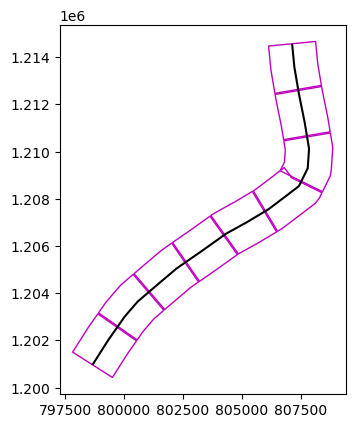

In [4]:
# -----Check if centerline polygons already exist in file
polygons_fn = os.path.join(data_path, 'velocity', 'centerline_polygons.gpkg')
if os.path.exists(polygons_fn):
    polygons_gdf = gpd.read_file(polygons_fn)
    print('Centerline polygons loaded from file')
else:
    # -----Create polygons from centerline
    cl_x, cl_y = cl.geometry[0].coords.xy
    # Length and width of each polygon
    length, width = 2e3, 2e3
    # Determine distance between split points
    dx = int(length / (cl_dist[1] - cl_dist[0]))
    # Determine number of polygons
    num_polygons = int(np.ceil(len(cl_dist) / dx))
    # Generate the polygons
    polygons = []
    # Iterate over polygons
    for i in range(num_polygons):
        # Crop centerline
        if dx*(i+1) < len(cl_dist):
            Iline = np.arange(dx*i, dx*(i+1))
        else:
            Iline = np.arange(dx*i, len(cl_dist))
        cl_x_line, cl_y_line = [cl_x[i] for i in Iline], [cl_y[i] for i in Iline]
        cl_line = LineString(list(zip(cl_x_line, cl_y_line)))
        # Create a buffer polygon around the LineString 
        polygon = cl_line.buffer(width / 2, cap_style='flat', join_style=2)
        polygons.append(polygon)
    
    # Reformat as geopandas.GeoDataFrame
    polygons_gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=cl.crs)
    # Save to file
    polygons_gdf.to_file(polygons_fn)
    print('Centerline polygons saved to file:', polygons_fn)

# Plot results
fig, ax = plt.subplots()
polygons_gdf.plot(ax=ax, facecolor='None', edgecolor='m')
cl.plot(ax=ax, color='k')
plt.show()

## Sample surface elevations in each polygon

In [24]:
# ------Check if polygon elevations already exist in file
h_polys_fn = os.path.join(data_path, 'surface_elevation', 'centerline_polygons_surface_elevation.csv')
if os.path.exists(h_polys_fn):
    h_polys_df = pd.read_csv(h_polys_fn)
    h_polys_df['Date'] = pd.DatetimeIndex(h_polys_df['Date'])
    print('Polygon elevations loaded from file.')
else:
    # Iterate over DEM file names
    dates = []
    datasets = []
    h_polys = np.nan*np.zeros((len(h_fns), len(polygons_gdf)))
    for i, fn in enumerate(h_fns):
        h_xda = rxr.open_rasterio(fn)
        h_xda = xr.where(np.abs(h_xda) > 10e3, np.nan, h_xda)
        h_xda = h_xda.rio.write_crs('EPSG:3338')
        dates.append(os.path.basename(fn)[0:10])
        datasets.append(os.path.basename(fn).split('_')[1])
        # Sample surface elevations in each polygon
        for j in range(len(polygons_gdf)):
            h_polys[i,j] = np.nanmean(h_xda.rio.clip(polygons_gdf.iloc[j], polygons_gdf.crs).data)
    # Reformat as dataframe
    h_polys_df = pd.DataFrame({'Date': dates,
                               'Dataset': datasets})
    for j in range(len(polygons_gdf)):
        df = pd.DataFrame({f'Polygon {j+1}': h_polys[:,j]})
        h_polys_df = pd.concat([h_polys_df, df], axis=1)
    h_polys_df
    # Save to file
    h_polys_df.to_csv(h_polys_fn, index=False)
    print('Centerline polygons surface elevations saved to file:', h_polys_fn)

h_polys_df['Year'] = pd.DatetimeIndex(h_polys_df['Date']).year    
h_polys_df['Month'] = pd.DatetimeIndex(h_polys_df['Date']).month
h_polys_df

Polygon elevations loaded from file.


,Date,Dataset,Polygon 1,Polygon 2,Polygon 3,Polygon 4,Polygon 5,Polygon 6,Polygon 7,Polygon 8,Polygon 9,Year,Month
0,2009-02-22,ArcticDEM,NaN,NaN,NaN,NaN,NaN,252.235949,249.402748,209.457177,143.880466,2009,2
1,2011-09-25,ArcticDEM,883.006454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,9
2,2012-03-21,OIB,725.658796,658.247426,581.996884,430.266165,333.273677,301.973038,255.609928,229.657289,155.440120,2012,3
3,2012-05-24,OIB,700.847446,657.151037,585.947093,397.270290,339.095473,330.114996,NaN,NaN,179.084094,2012,5
4,2013-05-21,OIB,725.407672,654.623327,578.187789,419.998602,336.508595,309.507529,NaN,NaN,129.150609,2013,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2023-07-02,ICESat-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,7
124,2023-07-29,ICESat-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,7
125,2023-07-31,ICESat-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,7
126,2023-08-02,ICESat-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,8


## Subtract the mean elevation from each polygon

In [36]:
poly_cols = [x for x in list(h_polys_df.columns) if 'Polygon' in x]
h_polys_demean_df = h_polys_df.copy()
for col in poly_cols:
    h_polys_demean_df[col] = h_polys_demean_df[col] - h_polys_demean_df[col].median()
    # Remove wacky values
    h_polys_demean_df.loc[h_polys_demean_df[col] > 100, col] = np.nan
h_polys_demean_df

,Date,Dataset,Polygon 1,Polygon 2,Polygon 3,Polygon 4,Polygon 5,Polygon 6,Polygon 7,Polygon 8,Polygon 9,Year,Month
0,2009-02-22,ArcticDEM,NaN,NaN,NaN,NaN,NaN,-48.684140,0.975136,-5.992899,-0.127907,2009,2
1,2011-09-25,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,9
2,2012-03-21,OIB,1.560046,4.010109,6.754382,9.266206,0.000000,1.052949,7.182316,14.207213,11.431747,2012,3
3,2012-05-24,OIB,-23.251304,2.913720,10.704590,-23.729669,5.821796,29.194907,NaN,NaN,35.075721,2012,5
4,2013-05-21,OIB,1.308922,0.386010,2.945287,-1.001356,3.234918,8.587441,NaN,NaN,-14.857764,2013,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2023-07-02,ICESat-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,7
124,2023-07-29,ICESat-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,7
125,2023-07-31,ICESat-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,7
126,2023-08-02,ICESat-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,8


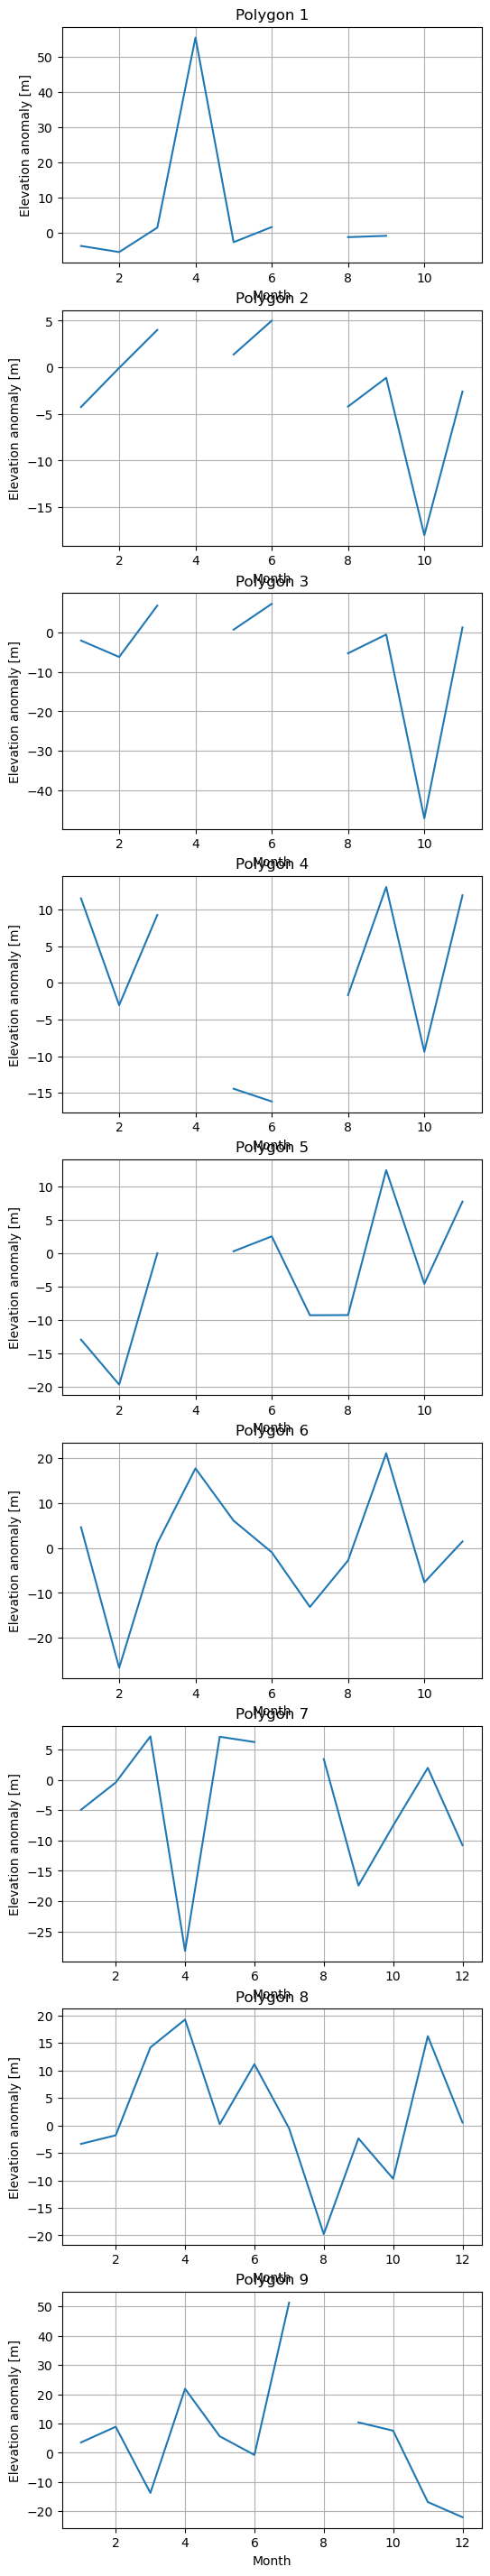

In [37]:
# Plot results
fig, ax = plt.subplots(len(poly_cols), 1, figsize=(6, 4*len(poly_cols)))
for i, col in enumerate(poly_cols):
    h_polys_demean_df.groupby('Month')[col].mean().plot(ax=ax[i])
    ax[i].set_title(col)
    ax[i].grid()
    ax[i].set_ylabel('Elevation anomaly [m]')
plt.show()